In [1]:
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse

In [2]:
from scipy.stats import multivariate_normal as mvn

In [3]:
def em_gmm_orig(xs, pis, mus, sigmas, tol=0.01, max_iter=100):
    #Esta función implementa el algorithm de EM para mezclas de distribuciones Gaussianas 
    #Esta implementación esta hecha solamente para ilustrar el procedimento.
    #No usar en casos reales. 
    #Una implementación eficiente está data por 
    #from sklearn import mixture
    #mixture.GaussianMixture
    #La cual será discutida en el siguiente tutorial

    n, p = xs.shape
    k = len(pis)
    list1=[]
    list2=[]
    list3=[]
    list4=[]
    ll_old = 0
    for i in range(max_iter):
        list2.append(pis)
        list3.append(mus)
        list4.append(sigmas)
        exp_A = []
        exp_B = []
        ll_new = 0

        # Paso E (Esperanza)
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0)

        # Paso M (Maximización)
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n

        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

        # Actualizar lel logaritmo de la verosimilitud
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
        list1.append(ll_new)

    return ll_new, pis, mus, sigmas,list1,list2,list3,list4

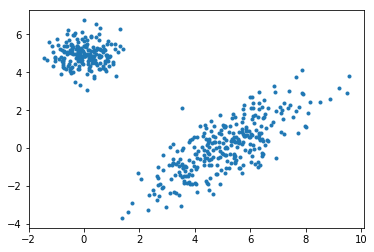

In [4]:
np.random.seed(123)

#  Genera unos datos
n = 500
_mus = np.array([[0,5], [5,0]])
_sigmas = np.array([[[.35, 0], [0, .35]], [[2,1.5],[1.5,2]]])
_pis = np.array([0.4, 0.6])
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n))
                    for pi, mu, sigma in zip(_pis, _mus, _sigmas)])

plt.plot(xs[:,0],xs[:,1],'.')
plt.show()

In [5]:
# Valores Iniciales
pis = np.random.random(2)
pis /= pis.sum()
pis = [.5,.5]
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2)


In [6]:
#sigmas[0][0,0]=10000
#sigmas[0][1,1]=1
#sigmas[1][0,0]=1
#sigmas[1][1,1]=10000

In [7]:
ll1, pis1, mus1, sigmas1, l1, l2, l3, l4 = em_gmm_orig(xs, pis, mus, sigmas)

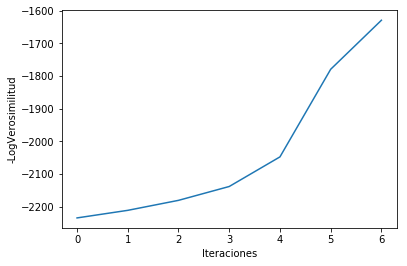

In [8]:
plt.plot(l1)
plt.xlabel('Iteraciones')
plt.ylabel('-LogVerosimilitud')
plt.show()

In [9]:

l3=np.array(l3)

In [10]:
l3.shape

(8, 2, 2)

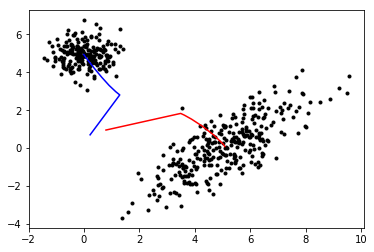

In [11]:
plt.plot(xs[:,0],xs[:,1],'.k')
plt.plot(l3[:,0,0],l3[:,0,1],'-b')
plt.plot(l3[:,1,0],l3[:,1,1],'-r')
plt.show()

In [12]:
def plot_cov_ellipse(cov, pos, nstd=.2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

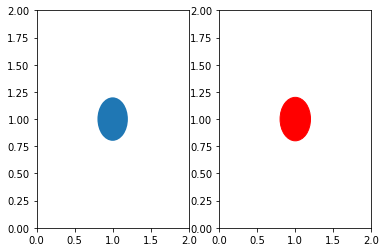

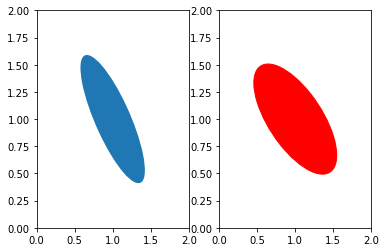

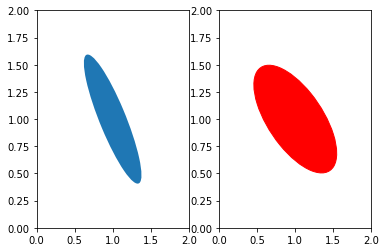

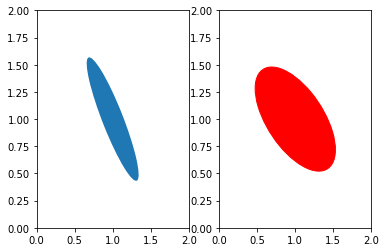

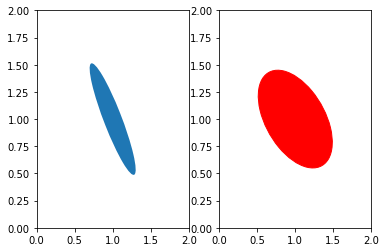

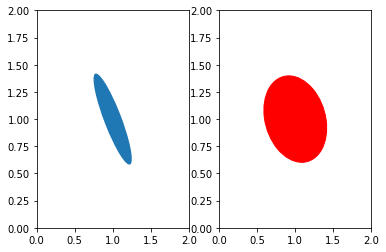

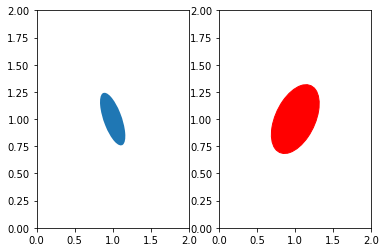

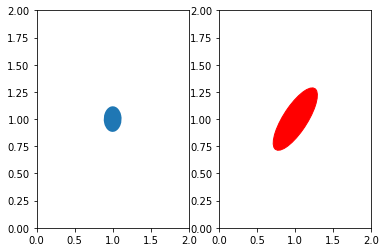

In [13]:
for mi in l4:
    plt.subplot(121)
    plot_cov_ellipse(mi[0],[1,1],nstd=.2)
    plt.xlim([0,2])
    plt.ylim([0,2])
    plt.subplot(122)
    plot_cov_ellipse(mi[1],[1,1],nstd=.2,color='r')
    plt.xlim([0,2])
    plt.ylim([0,2])
    plt.show()

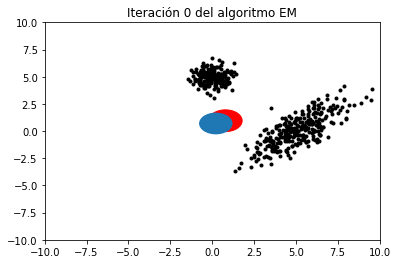

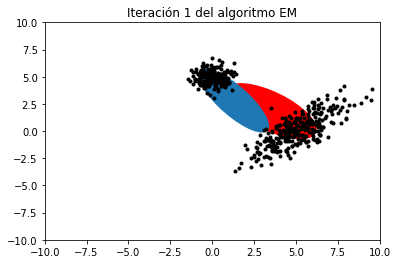

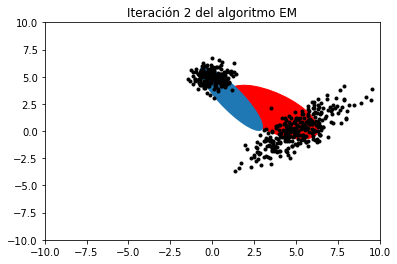

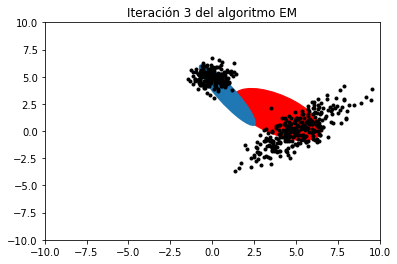

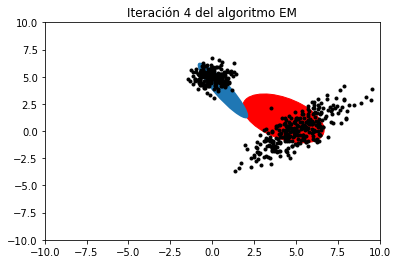

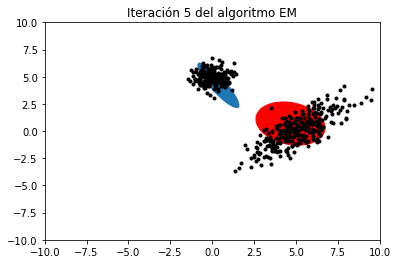

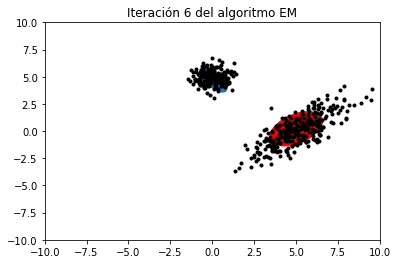

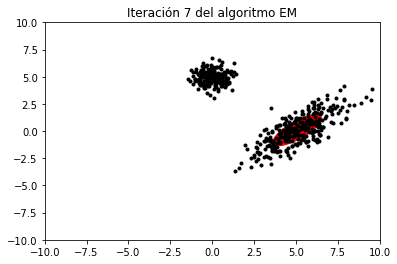

In [21]:
i=0
for mui,covi in zip(l3,l4):
    plt.plot(xs[:,0],xs[:,1],'.k')
    plt.title('Iteración '+str(i)+' del algoritmo EM')
    plot_cov_ellipse(covi[1],mui[1],nstd=1,color='r')
    plot_cov_ellipse(covi[0],mui[0],nstd=1)
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    i+=1
    plt.show()

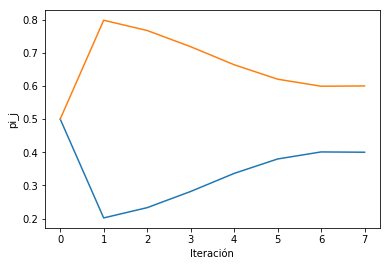

In [22]:
plt.plot(l2)
plt.xlabel('Iteración')
plt.ylabel('pi_j')
plt.show()

In [23]:
#Probabilidad de pertenecer a cada clase.
l2[-1]

array([0.40001297, 0.59998703])

In [24]:
#Estimación final de los vectores media.
l3[-1]

array([[-0.00628532,  4.94084075],
       [ 5.08101653,  0.08587486]])

In [25]:
#Estimación final de las matrices de covarianza
l4[-1]

array([[[0.34230348, 0.00383985],
        [0.00383985, 0.34739239]],

       [[2.10528513, 1.59628159],
        [1.59628159, 2.05767594]]])